In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import mapboxgl
from mapboxgl.viz import*
from mapboxgl.utils import *
from mapboxgl.utils import df_to_geojson
from mapboxgl.utils import create_color_stops
from pyproj import Proj, transform
from config import token


pd.options.display.max_columns=None
pd.options.display.max_rows=None

import scipy as sp
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import kstest
from scipy.stats import anderson
from scipy.stats import jarque_bera
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.stats import chisquare
from scipy.stats import probplot
from scipy.stats import bootstrap

from scipy.interpolate import Rbf

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

In [2]:
df = pd.read_excel('df.xlsx')
df_copy = df.copy()
df = df.drop(['name','관정깊이(m)', '자연수위(dtw, m)', '토지이용'], axis=1)

In [3]:
parameters = ['X','Y','pH','Cl','NO3-N','SO4','Na','K','Mg']
df[parameters] = df[parameters].apply(pd.to_numeric, errors='coerce', axis=1)

In [4]:
df = df.dropna(subset=['X', 'Y', 'elevation', 'year', 'month', 'EC', 'pH', 'HCO3', 'Cl', 'NO3-N', 'SO4', 'Na', 'K', 'Mg', 'Ca'])

In [5]:
df[df['pH']<=6]
df = df.drop([2154,3317,5263])
df = df.drop([2772,2773,4776,4777,4778,4780,4781,4782,4783,4784,4785], axis=0)
df = df.reset_index(drop=True)

In [6]:
proj_TM = Proj(init='epsg:5175')
proj_WGS84 = Proj(init='epsg:4326')

def transform_TM_to_w84(df):
    return pd.Series(transform(proj_TM, proj_WGS84, df['X'], df['Y']), index=['X','Y'])

df[['X', 'Y']]= df.apply(transform_TM_to_w84, axis=1)

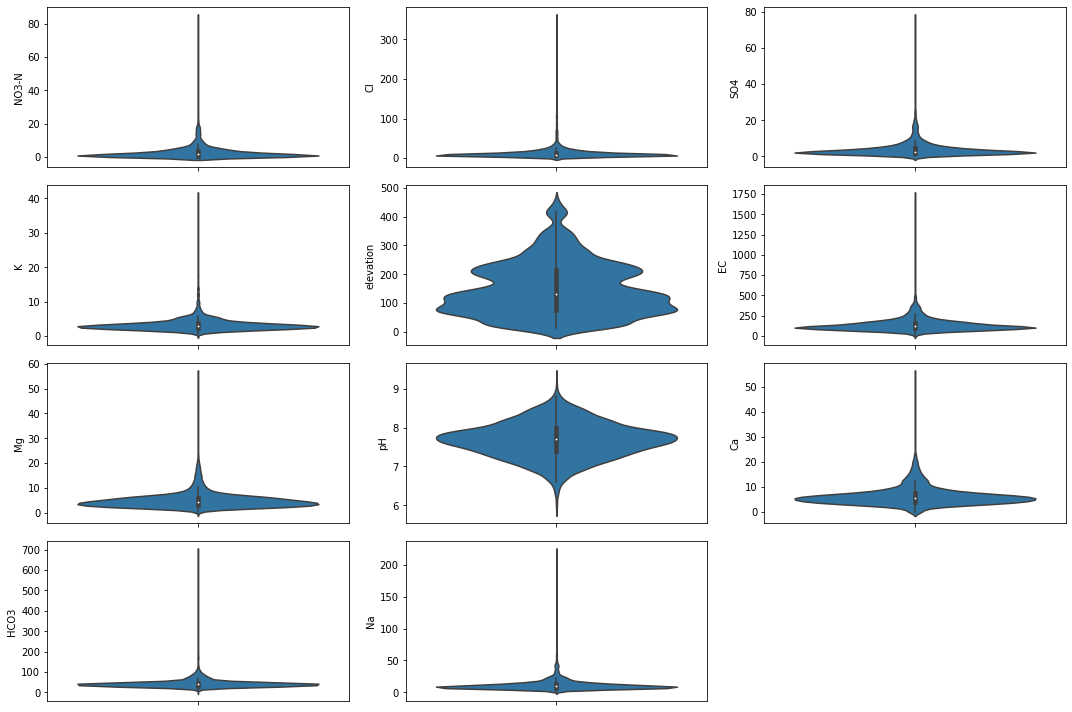

In [7]:
plt.figure(figsize=(15,10))

for i,col in enumerate(df[{'elevation','EC','pH','HCO3','Cl','NO3-N','SO4','Na','K','Mg','Ca'}]):
    plt.subplot(4,3,i + 1)
    sns.violinplot(y=col, data=df)
    
plt.tight_layout()

plt.show()

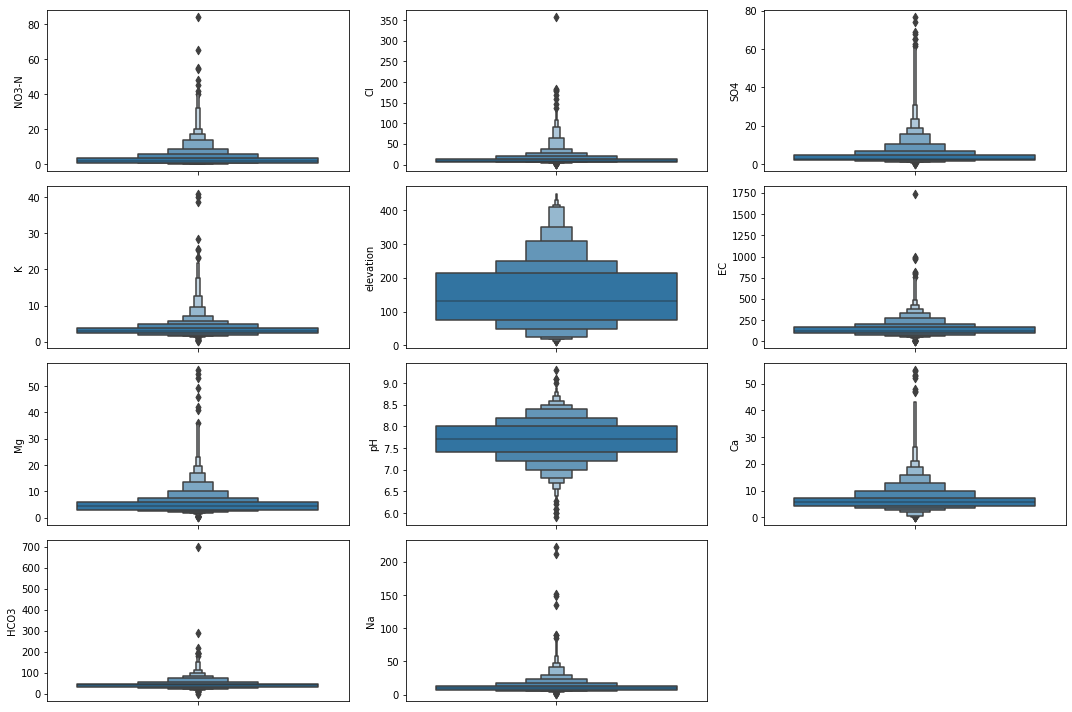

In [8]:
plt.figure(figsize=(15,10))

for i,col in enumerate(df[{'elevation','EC','pH','HCO3','Cl','NO3-N','SO4','Na','K','Mg','Ca'}]):
    plt.subplot(4,3,i + 1)
    sns.boxenplot(y=col, data=df)
    
plt.tight_layout()

plt.show()

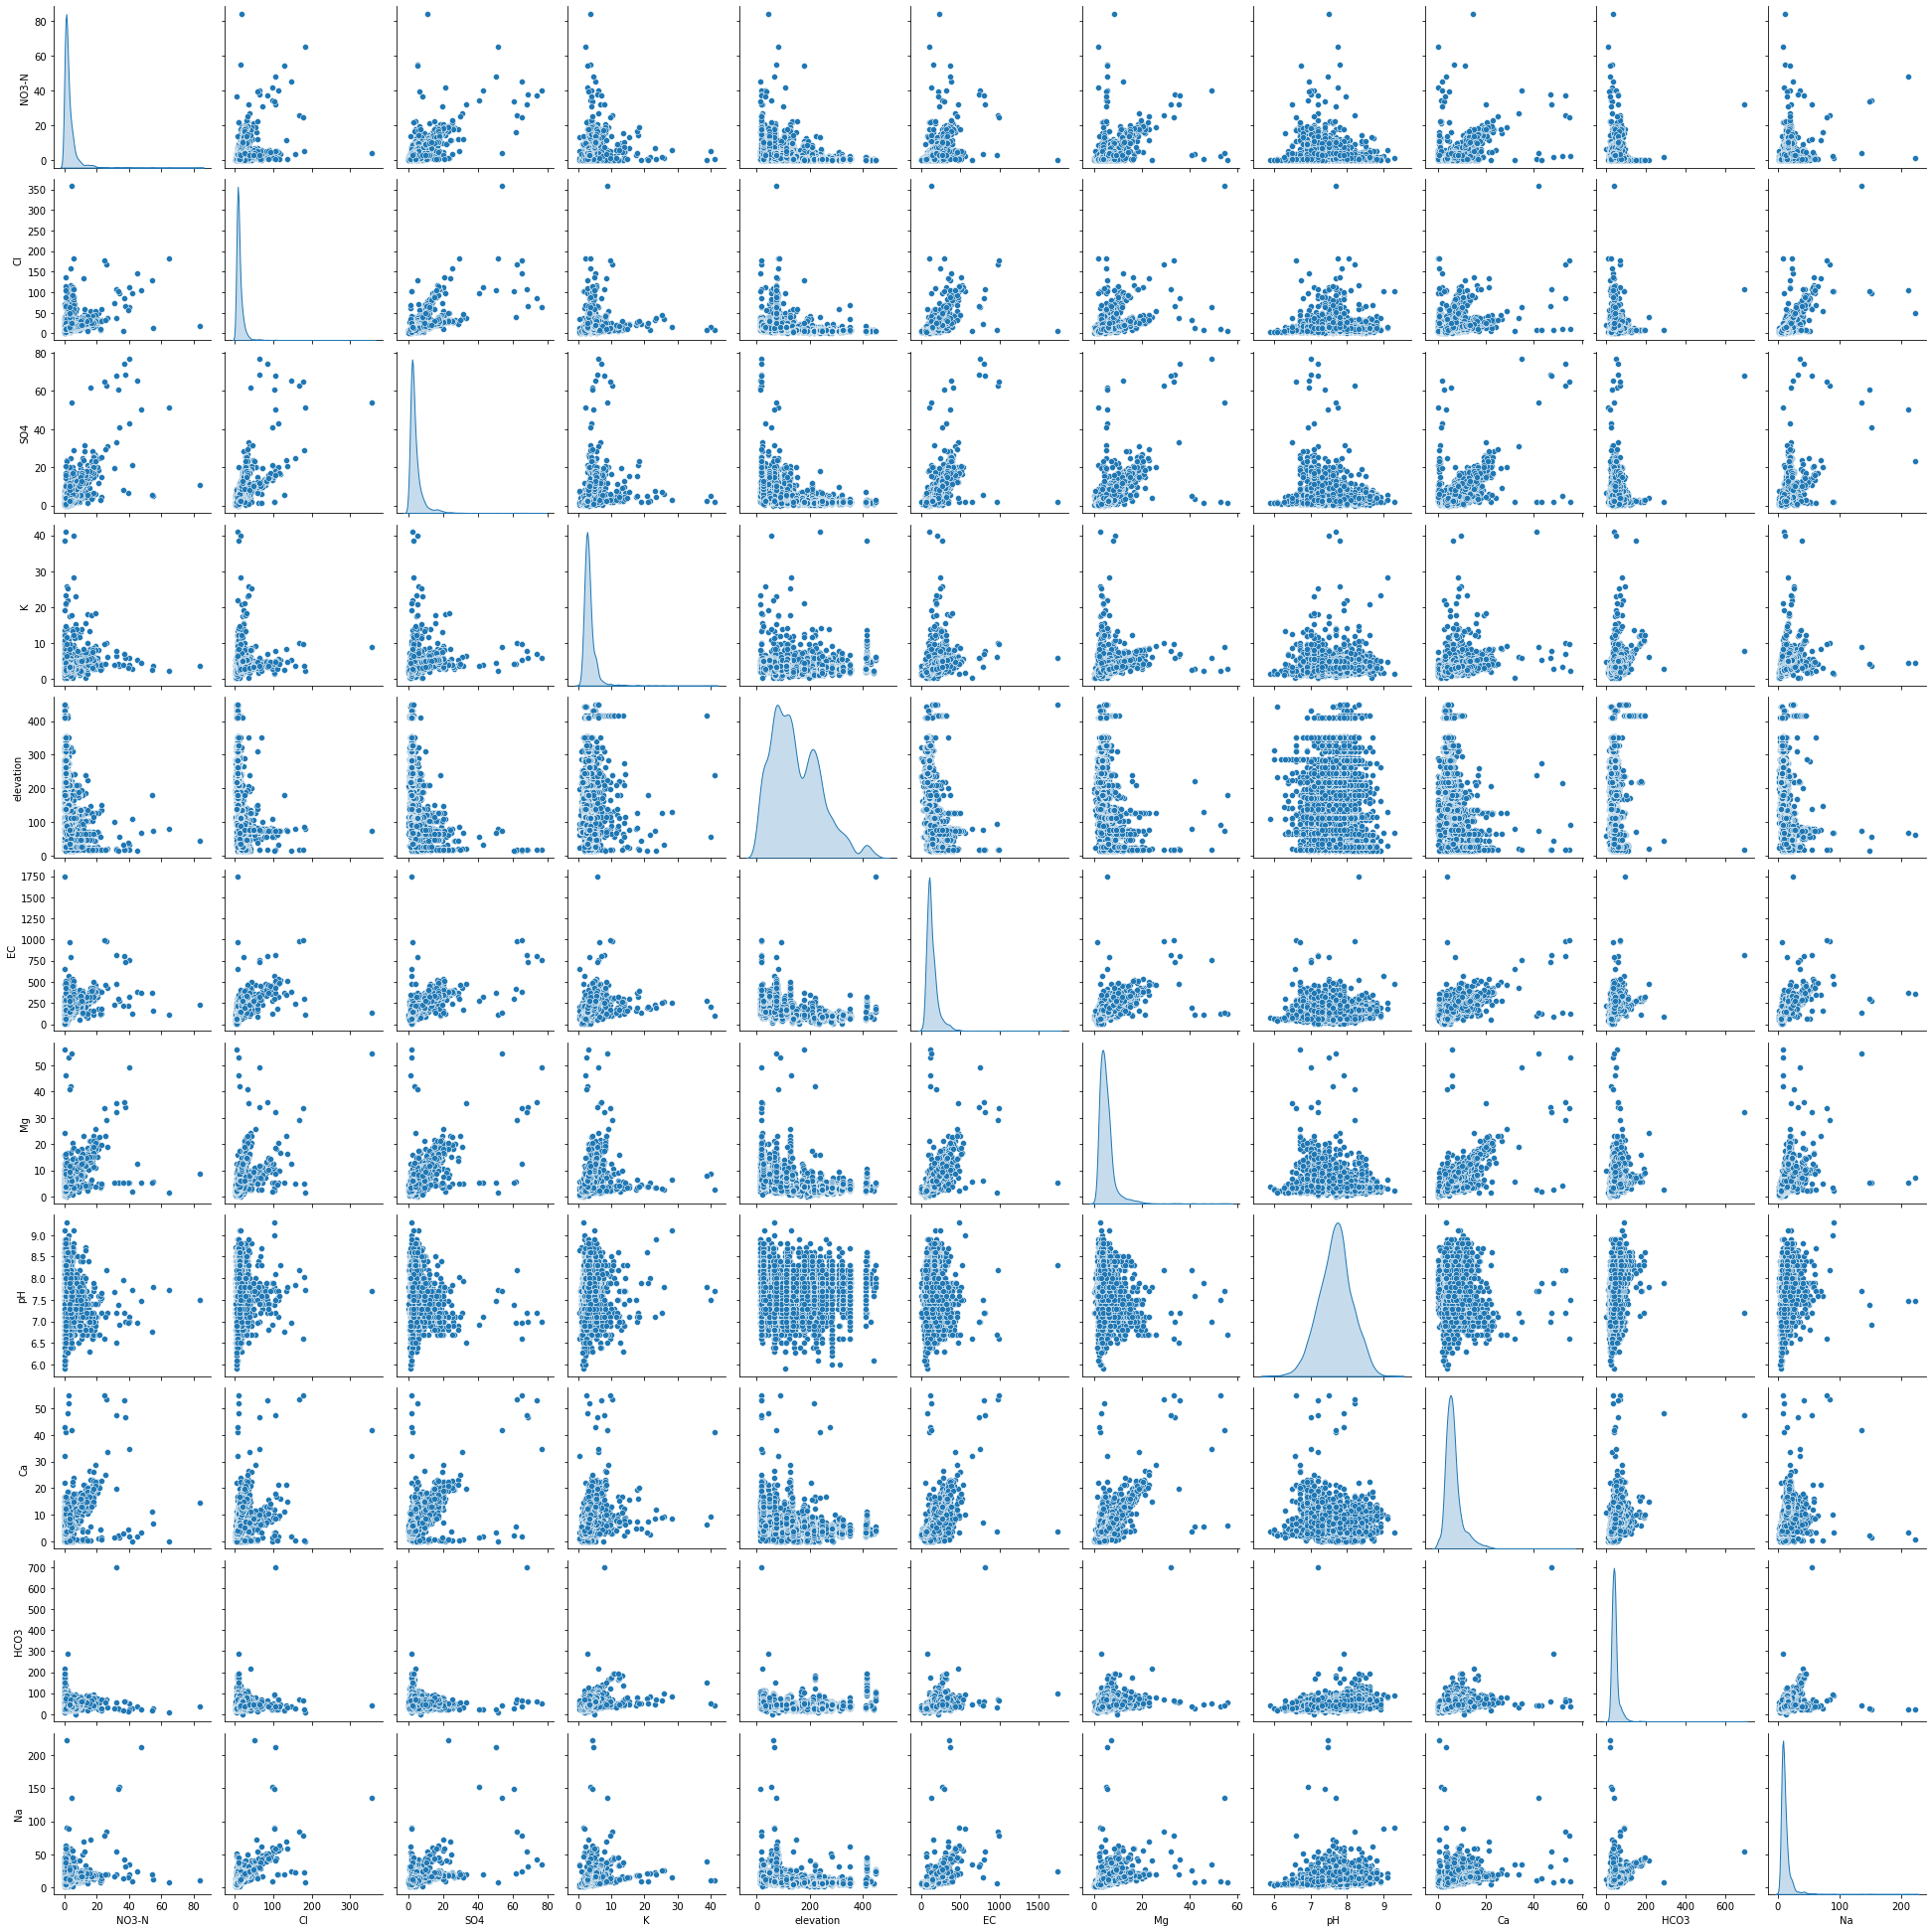

In [10]:
sns.pairplot(df[{'elevation','EC','pH','HCO3','Cl','NO3-N','SO4','Na','K','Mg','Ca'}], diag_kind="kde");

<AxesSubplot:>

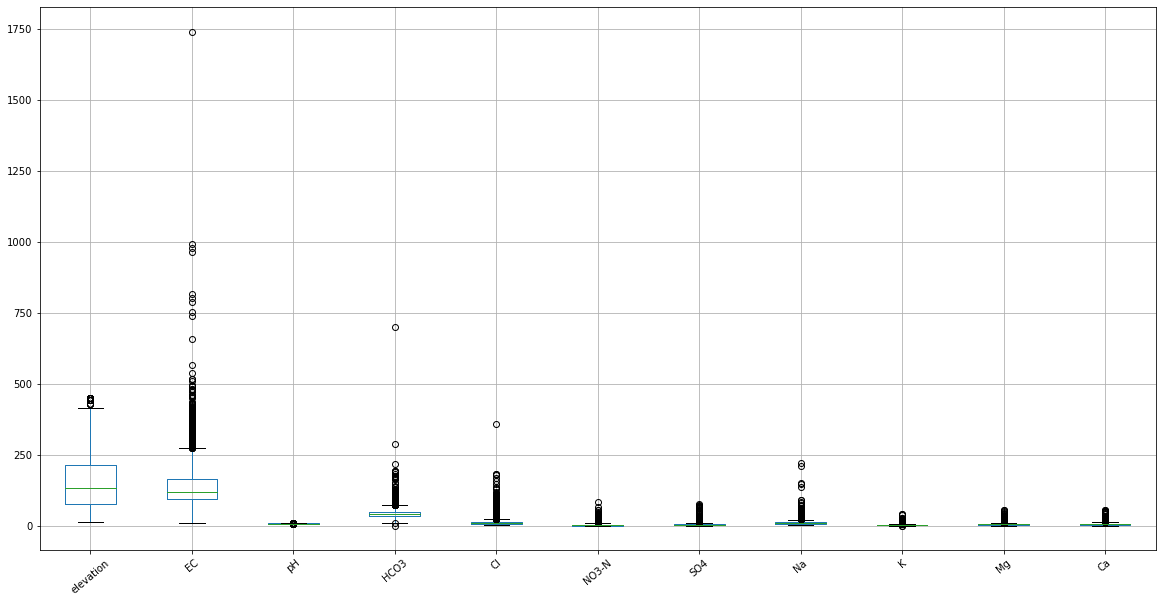

In [11]:
df.boxplot(column = ['elevation', 'EC', 'pH','HCO3','Cl','NO3-N','SO4','Na','K','Mg','Ca'], rot=40, figsize = (20,10))

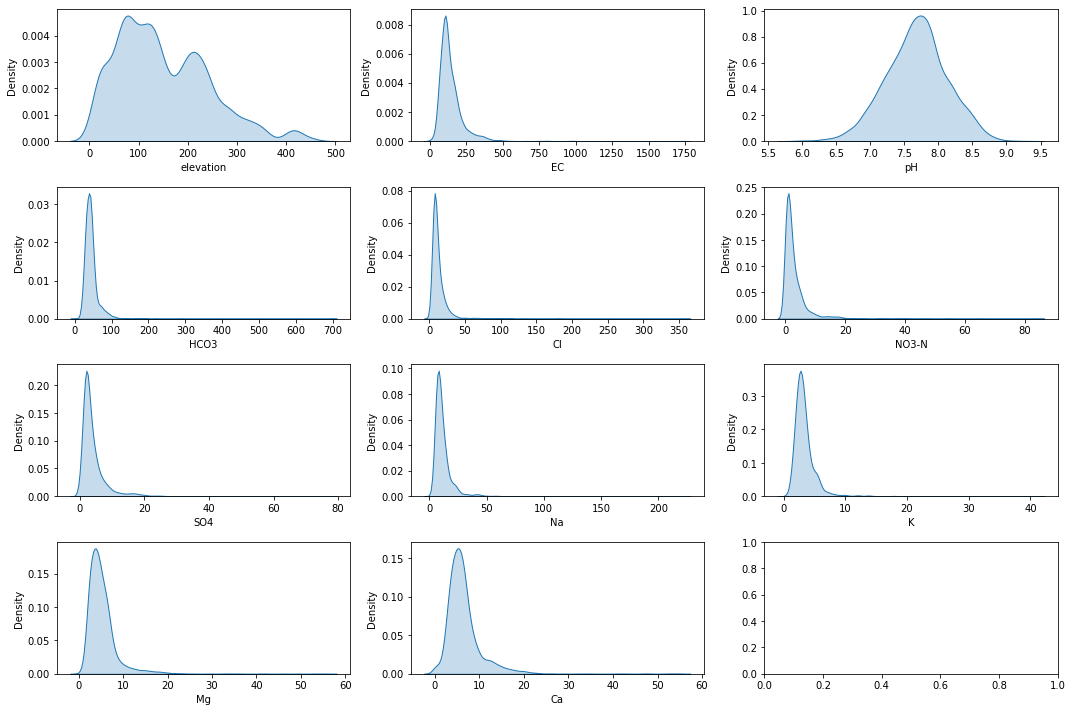

In [12]:
f, axs = plt.subplots(4,3,figsize=(15,10))

sns.kdeplot(data=df['elevation'], shade=True, ax=axs[0,0])
sns.kdeplot(data=df['EC'], shade=True, ax=axs[0,1])
sns.kdeplot(data=df['pH'], shade=True, ax=axs[0,2])
sns.kdeplot(data=df['HCO3'], shade=True, ax=axs[1,0])
sns.kdeplot(data=df['Cl'], shade=True, ax=axs[1,1])
sns.kdeplot(data=df['NO3-N'], shade=True, ax=axs[1,2])
sns.kdeplot(data=df['SO4'], shade=True, ax=axs[2,0])
sns.kdeplot(data=df['Na'], shade=True, ax=axs[2,1])
sns.kdeplot(data=df['K'], shade=True, ax=axs[2,2])
sns.kdeplot(data=df['Mg'], shade=True, ax=axs[3,0])
sns.kdeplot(data=df['Ca'], shade=True, ax=axs[3,1])
sns.kdeplot(data=None, shade=True, ax=axs[3,2])
f.tight_layout()

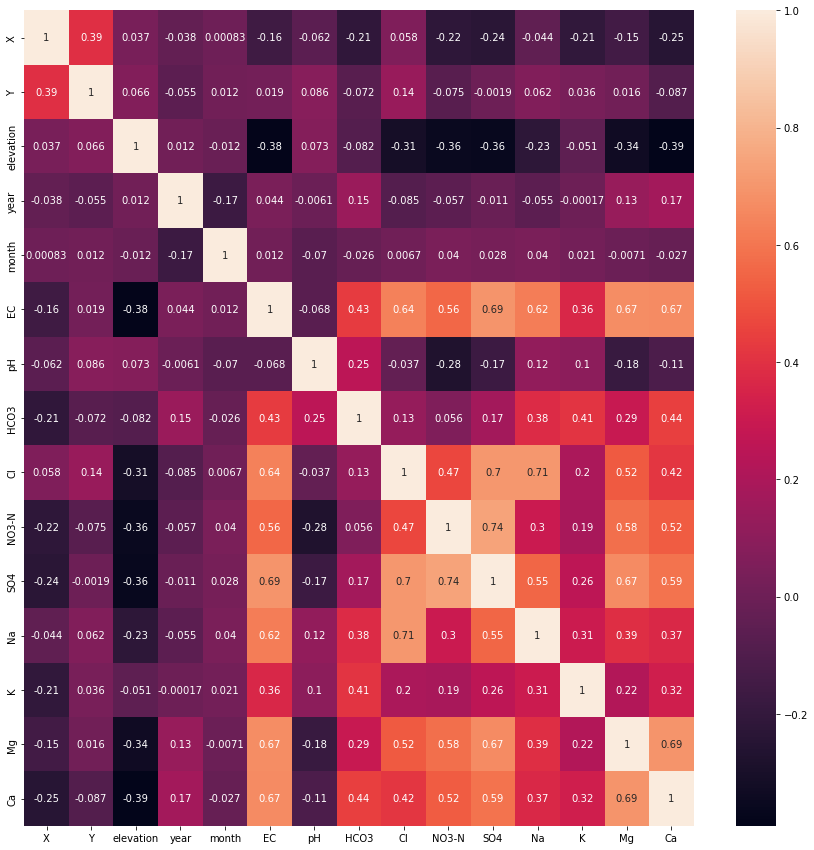

In [13]:
corr_df = df.corr(method='pearson')
plt.figure(figsize=(15, 15))
sns.heatmap(corr_df, annot=True)
plt.show()

In [14]:
df_year = df.groupby('year')
df_year.describe()

X                                                            \
      count        mean       std         min         25%         50%   
year                                                                    
1993    2.0  126.489171  0.027949  126.469408  126.479289  126.489171   
1996    2.0  126.489171  0.027949  126.469408  126.479289  126.489171   
1998   43.0  126.520553  0.217027  126.167914  126.346766  126.469330   
1999   43.0  126.519698  0.216585  126.167914  126.346766  126.469330   
2008  543.0  126.562102  0.194889  126.178174  126.406647  126.566090   
2009  251.0  126.559403  0.203259  126.174474  126.379008  126.555877   
2010  256.0  126.568951  0.206856  126.178174  126.381376  126.575703   
2011  255.0  126.558941  0.203032  126.178174  126.368533  126.567750   
2012  259.0  126.523121  0.218853  126.178174  126.314669  126.501475   
2013  300.0  126.546862  0.211162  126.178174  126.344264  126.560698   
2014  306.0  126.545274  0.214604  126.178174  126.342105  126.560698   
2015  312.0  126.550136  0.212618  126.178174  126.344264  126.572860   
2016  213.0  126.549811  0.212685  126.178174  126.344983  126.570016   
2017  362.0  126.537803  0.213220  126.178174  126.338885  126.535530   
2018  374.0  126.539804  0.215542  126.178174  126.338885  126.535530   
2019  172.0  126.505052  0.224696  126.178174  126.295315  126.451543   
2020  248.0  126.528405  0.216554  126.178174  126.336116  126.505540   
2021  122.0  126.527570  0.218336  126.178174  126.332982  126.501565   

                                  Y                                  \
             75%         max  count       mean       std        min   
year                                                                  
1993  126.499052  126.508933    2.0  33.485986  0.011712  33.477704   
1996  126.499052  126.508933    2.0  33.485986  0.011712  33.477704   
1998  126.704133  126.857810   43.0  33.396708  0.088734  33.246817   
1999  126.704133  126.857810   43.0  33.402093  0.087326  33.246817   
2008  126.726660  126.877947  543.0  33.390810  0.090044  33.238335   
2009  126.756198  126.877947  251.0  33.382143  0.086244  33.238335   
2010  126.759299  126.901999  256.0  33.384672  0.086577  33.238335   
2011  126.756198  126.877947  255.0  33.381127  0.086100  33.246817   
2012  126.714508  126.877947  259.0  33.374091  0.084448  33.238335   
2013  126.728694  126.877947  300.0  33.379138  0.083811  33.238335   
2014  126.728694  126.877947  306.0  33.378004  0.084470  33.238335   
2015  126.727130  126.877947  312.0  33.379392  0.083314  33.238335   
2016  126.726609  126.877947  213.0  33.379250  0.083457  33.238335   
2017  126.725958  126.877947  362.0  33.380010  0.082429  33.238335   
2018  126.728694  126.877947  374.0  33.378488  0.083532  33.211546   
2019  126.714736  126.877947  172.0  33.377115  0.084282  33.211546   
2020  126.724655  126.877947  248.0  33.375799  0.085138  33.211546   
2021  126.725958  126.877947  122.0  33.376421  0.084631  33.211546   

                                                 elevation              \
            25%        50%        75%        max     count        mean   
year                                                                     
1993  33.481845  33.485986  33.490127  33.494268       2.0   88.750000   
1996  33.481845  33.485986  33.490127  33.494268       2.0   88.750000   
1998  33.317472  33.409044  33.465503  33.535143      43.0  119.773488   
1999  33.336841  33.429857  33.468379  33.535143      43.0  121.471163   
2008  33.289736  33.427449  33.469456  33.544035     543.0  143.881823   
2009  33.295872  33.385513  33.464081  33.537816     251.0  159.104980   
2010  33.294100  33.384302  33.471600  33.537816     256.0  150.989512   
2011  33.293738  33.385513  33.460793  33.537816     255.0  159.701627   
2012  33.291335  33.369868  33.455877  33.518113     259.0  138.541490   
2013  33.294010  33.383816  33.459407  33.518113     300.0  153.613800   
2014  33.293738  33.38

((array([-3.5818493 , -3.34321692, -3.21152295, ...,  3.21152295,
          3.34321692,  3.5818493 ]),
  array([ 13.89,  13.89,  13.89, ..., 450.  , 450.  , 450.  ])),
 (90.26966993617691, 148.96490278119617, 0.9744955845399663))

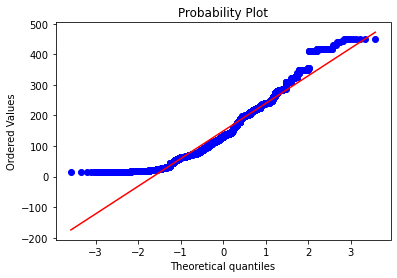

In [15]:
stats.probplot(df.elevation, dist='norm', plot=plt)

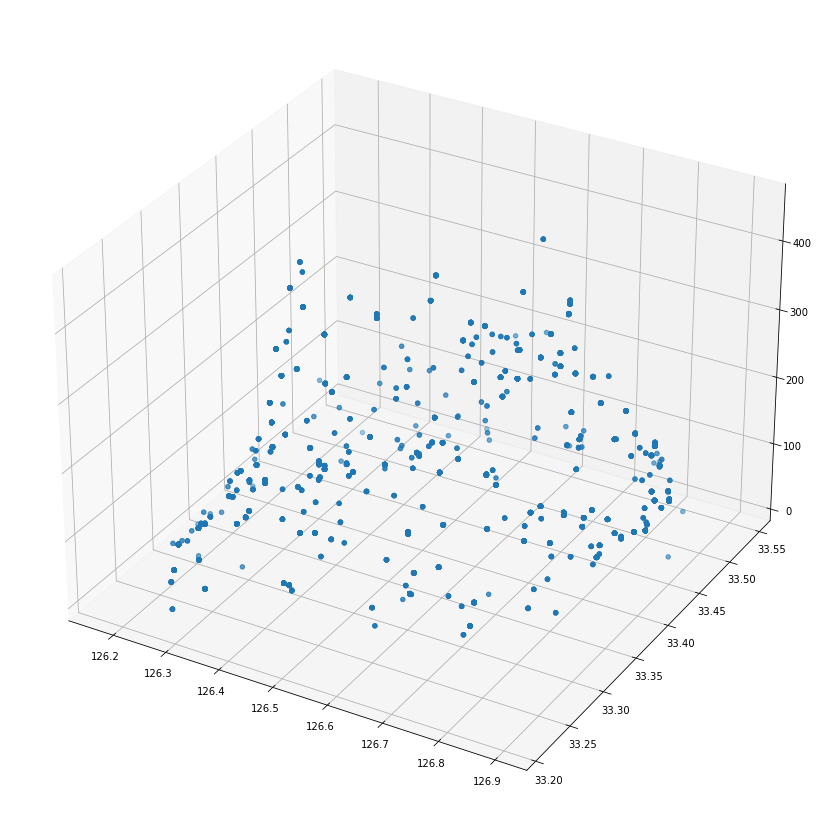

In [16]:
x = df['X']
y = df['Y']
z = df['elevation']
X, Y = np.meshgrid(x, y)
Z = np.meshgrid(z)

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

x = x
y = y
z = z
ax.scatter(x,y,z)
plt.show()

In [17]:
geo_data = df_to_geojson(df=df, lat='Y', lon='X')

color_breaks = [0, 5, 10, 20, 40, 100, 400]
color_stops = create_color_stops(color_breaks, colors='BuPu')

center = [126.566, 33.352]

viz = CircleViz(access_token= token,
                data=geo_data,
                height='800px',
                color_property = "Cl",
                color_stops = color_stops,
#                 style='mapbox://styles/mapbox/dark-v10',
                center = center,
                zoom = 9.5,
                below_layer = 'waterway-label')

viz.show()

In [18]:
dup_X = df.duplicated(['X'])
dup_Y = df.duplicated(['Y'])
df_dup = pd.concat([df, dup_X, dup_Y], axis=1)
df_dup.rename(columns={0:'Dup_X', 1:'Dup_Y'}, inplace=True)
df_dup_remove = df_dup.drop_duplicates(['X', 'Y'])

In [19]:
extent = x_min, x_max, y_min, y_max = [df_dup_remove.X.min()-0.1, df_dup_remove.X.max()+0.1,
                                       df_dup_remove.Y.min()-0.1, df_dup_remove.Y.max()+0.1]

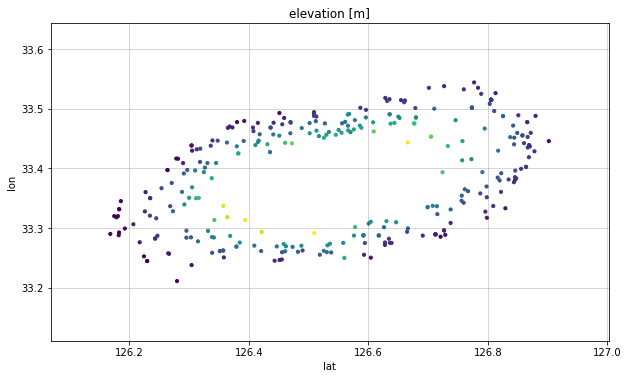

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(df_dup_remove.X, df_dup_remove.Y, c=df_dup_remove.elevation, s=10)
ax.set_aspect(1)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
ax.set_xlabel('lat')
ax.set_ylabel('lon')
ax.set_title('elevation [m]')
ax.grid(c='k', alpha=0.2)

plt.show()

In [21]:
xx = np.linspace(126, 126.99, 500)
yy = np.linspace(33.20, 33.60, 500)

xxx, yyy =  np.meshgrid(xx, yy)

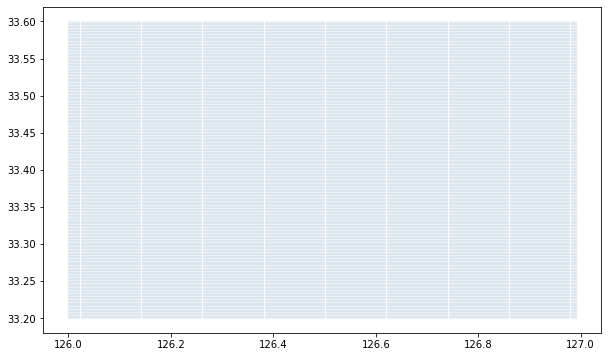

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(xxx, yyy, s=0.0005)

In [23]:
rbfi = Rbf(df_dup_remove.X, df_dup_remove.Y, df_dup_remove.elevation)
di = rbfi(xxx, yyy)

In [24]:
mi = np.min(np.hstack([di.ravel(), df_dup_remove.elevation.values]))
ma = np.max(np.hstack([di.ravel(), df_dup_remove.elevation.values]))

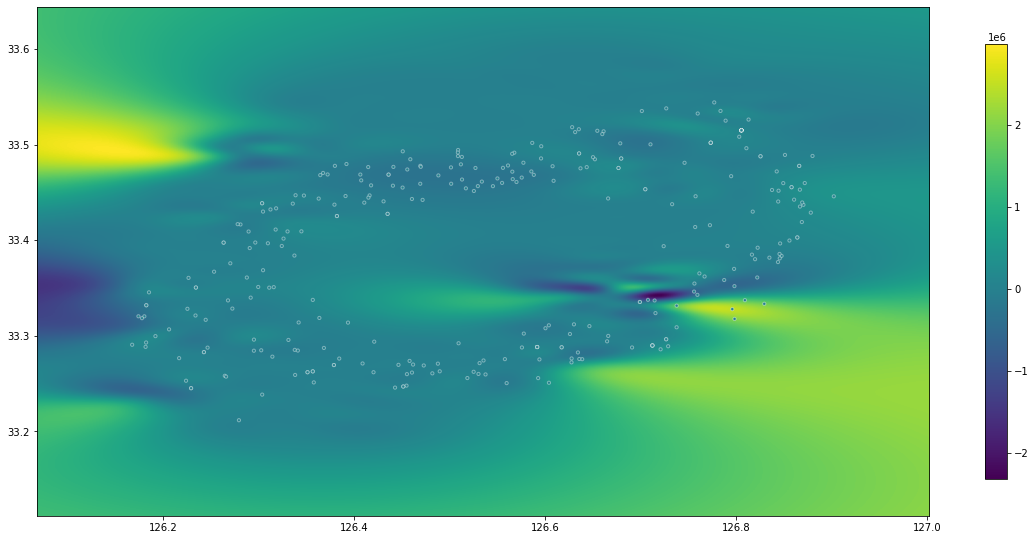

In [25]:
rbfi = Rbf(df_dup_remove.X, df_dup_remove.Y, df_dup_remove.elevation)
di = rbfi(xxx, yyy)

plt.figure(figsize=(20,20))
c1 = plt.imshow(di.T, origin="lower", extent=extent, vmin=mi, vmax=ma)
c2 = plt.scatter(df_dup_remove.X, df_dup_remove.Y, s=10, c=df_dup_remove.elevation,
                 edgecolor='#ffffff66', vmin=mi, vmax=ma)

plt.colorbar(c1, shrink=0.4)
plt.show()

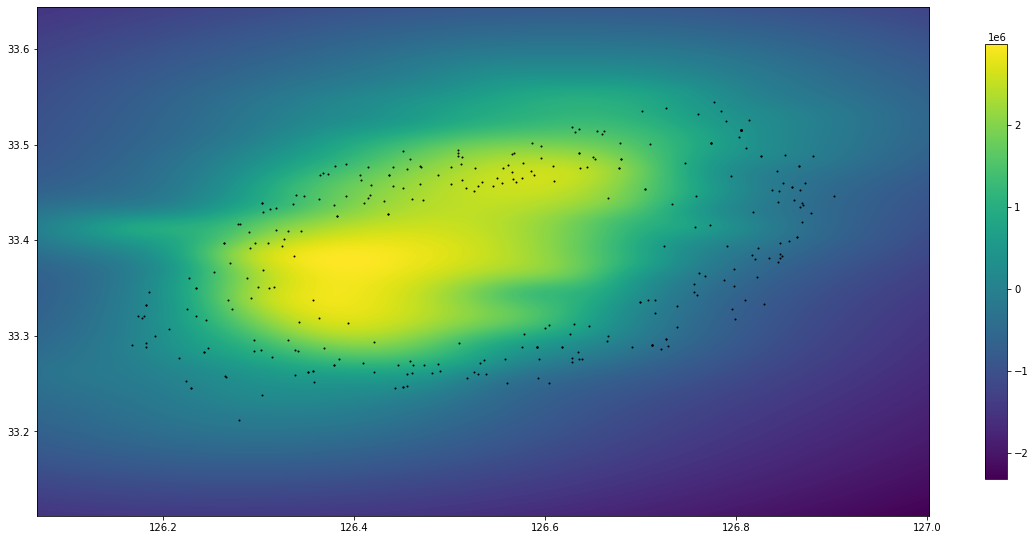

In [26]:
rbfi = Rbf(df_dup_remove.X, df_dup_remove.Y, df_dup_remove.elevation, smooth=0.25, kernel = 'gaussian')
di = rbfi(xxx, yyy)

plt.figure(figsize=(20,20))

plt.imshow(di.T, origin="lower", extent=extent)
plt.scatter(df_dup_remove.X, df_dup_remove.Y, s=1, c='k')
plt.colorbar(c1, shrink=0.4)

plt.show()


<AxesSubplot:xlabel='elevation', ylabel='Density'>

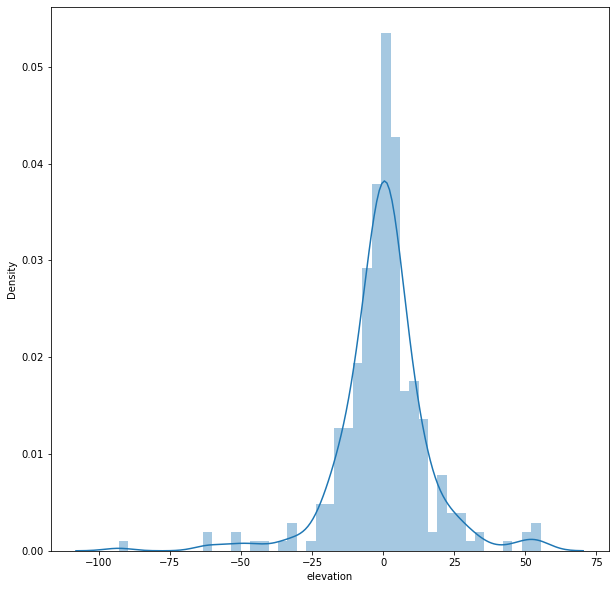

In [27]:
elevation_hat = rbfi(df_dup_remove.X, df_dup_remove.Y)

plt.figure(figsize=(10,10))

sns.distplot(elevation_hat - df_dup_remove.elevation)